Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Best Parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'base_estimator__max_depth': 15}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Classification Report with Best Parameters:
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         8
         3.0       0.92      1.00      0.96        12
         4.0       1.00      1.00      1.00         8
         5.0       1.00      1.00      1.00         7
         6.0       1.00      1.00      1.00        12
         7.0       1.00      1.00      1.00         9
         8.0       1.00      0.89      0.94         9
         9.0       1.00      0.91      0.95        11
        11.0       0.93      0.93      0.93        14
        12.0       1.00      1.00      1.00        14
        13.0       0.86      1.00      0.92         6
        15.0       1.00      1.00      1.00        11
        16.0       0.90      0.90      0.90        10
        17.0       1.00      0.80      0.89         5
        18.0       1.00      1.00      1.00        10
        20.0       1.00      0.89      0.94         9
        22.0       1.00      1.00    

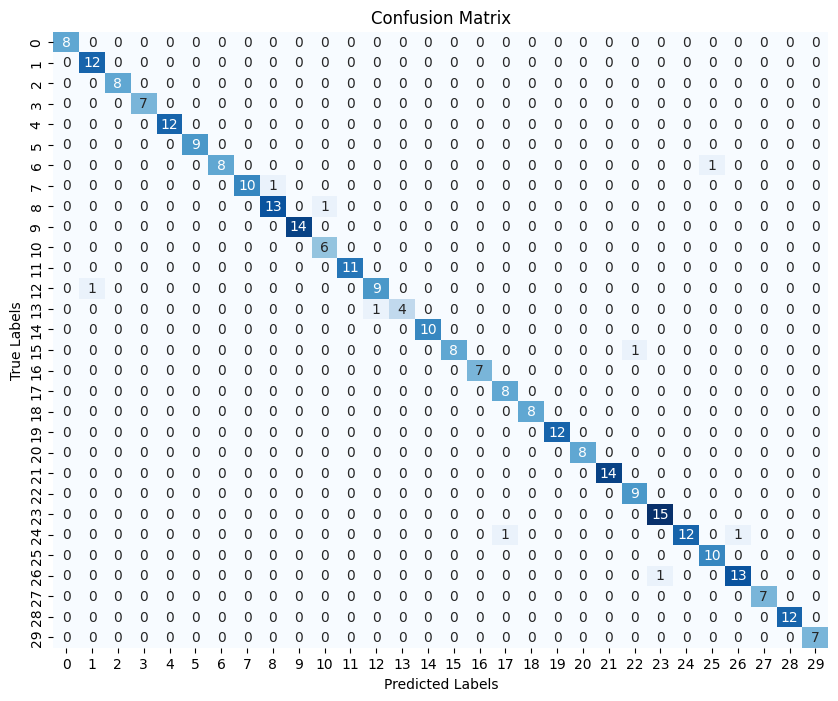

['/content/drive/My Drive/ada_model_random_search.joblib']

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install imbalanced-learn

import numpy as np
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
y = np.load("/content/drive/My Drive/yaleExtB_target.npy")
X = np.load("/content/drive/My Drive/yaleExtB_data.npy")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.astype(int)

# Check class balance and apply SMOTE if needed
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# PCA for dimensionality reduction
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

# Define the parameter grid for Randomized Search CV
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'learning_rate': [0.01, 0.025, 0.05, 0.1, 0.2, 0.5],
    # Use 'estimator__max_depth' if using scikit-learn version 1.2 and above
    'base_estimator__max_depth': [5, 7, 10, 15]
}

# Initialize AdaBoost classifier with base estimator as DecisionTreeClassifier
base_estimator = DecisionTreeClassifier(min_samples_split=20, min_samples_leaf=4, max_features='sqrt')
ada_classifier = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

# Perform Randomized Search CV
random_search = RandomizedSearchCV(ada_classifier, param_dist, n_iter=50, cv=3, random_state=42)
random_search.fit(X_train_pca, y_train_resampled)

# Get the best parameters found by Randomized Search CV
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Separate base_estimator parameters
base_estimator_params = {'max_depth': best_params.pop('base_estimator__max_depth')}
# Update the base estimator with the best max_depth found
updated_base_estimator = DecisionTreeClassifier(**base_estimator_params, min_samples_split=20, min_samples_leaf=4, max_features='sqrt')

# Instantiate AdaBoost classifier with the best parameters
ada_classifier_best = AdaBoostClassifier(base_estimator=updated_base_estimator, **best_params)

# Fit the AdaBoost classifier with the best parameters to training data
ada_classifier_best.fit(X_train_pca, y_train_resampled)

# Evaluate the model on test data
y_pred_ada_best = ada_classifier_best.predict(X_test_pca)
print("Classification Report with Best Parameters:")
print(classification_report(y_test, y_pred_ada_best))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_ada_best)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the trained model with the best parameters
joblib.dump(ada_classifier_best, '/content/drive/My Drive/ada_model_random_search.joblib')
